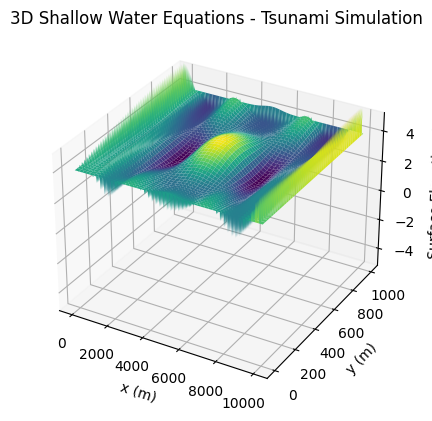

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Constants
g = 9.81  # gravitational acceleration (m/s^2)
H = 4.0  # mean water depth (m)
dt = 0.1  # time step (s)
dx = 10.0 # spatial step in x (m)
dy = 1.0  # spatial step in y (m)
Nx, Ny = 1000, 1000  # number of grid points

# Initialize the fields
eta = np.ones((Nx, Ny))*4  # surface elevation (m)
u = np.zeros((Nx, Ny))  # velocity in x direction (m/s)
v = np.zeros((Nx, Ny))  # velocity in y direction (m/s)

# Initial condition: a Gaussian hill resembling a tsunami
x = np.linspace(0, Nx*dx, Nx)
y = np.linspace(0, Ny*dy, Ny)
X, Y = np.meshgrid(x, y)
# Parameters for the Gaussian function
amplitude = 5.0  # amplitude of the tsunami wave (m)
spread_x = 0.05 * Nx * dx  # narrow spread of the Gaussian function in x
spread_y = 0.2 * Ny * dy  # broader spread of the Gaussian function in y
eta += amplitude * np.exp(-((X - Nx*dx/2)**2 / (2 * spread_x**2) + (Y - Ny*dy/2)**2 / (2 * spread_y**2)))

# Finite difference method
def compute_rhs(eta, u, v, dx, dy, g, H):
    eta_rhs = np.zeros_like(eta)
    u_rhs = np.zeros_like(u)
    v_rhs = np.zeros_like(v)

    # Compute the right-hand side for u and v (momentum equations)
    u_rhs[:, 1:-1] = -g * (eta[:, 2:] - eta[:, :-2]) / (2 * dx)
    v_rhs[1:-1, :] = -g * (eta[2:, :] - eta[:-2, :]) / (2 * dy)

    # Compute the right-hand side for eta (continuity equation)
    eta_rhs[1:-1, 1:-1] = -H * (
        (u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx) +
        (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dy)
    )

    return eta_rhs, u_rhs, v_rhs

# Time-stepping function using RK4
def rk4_step(eta, u, v, dt, dx, dy, g, H):
    k1_eta, k1_u, k1_v = compute_rhs(eta, u, v, dx, dy, g, H)
    k2_eta, k2_u, k2_v = compute_rhs(
        eta + 0.5 * dt * k1_eta, u + 0.5 * dt * k1_u, v + 0.5 * dt * k1_v, dx, dy, g, H
    )
    k3_eta, k3_u, k3_v = compute_rhs(
        eta + 0.5 * dt * k2_eta, u + 0.5 * dt * k2_u, v + 0.5 * dt * k2_v, dx, dy, g, H
    )
    k4_eta, k4_u, k4_v = compute_rhs(
        eta + dt * k3_eta, u + dt * k3_u, v + dt * k3_v, dx, dy, g, H
    )

    eta_new = eta + (dt / 6.0) * (k1_eta + 2 * k2_eta + 2 * k3_eta + k4_eta)
    u_new = u + (dt / 6.0) * (k1_u + 2 * k2_u + 2 * k3_u + k4_u)
    v_new = v + (dt / 6.0) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)

    return eta_new, u_new, v_new

# Time-stepping function for animation
def update(frame):
    global eta, u, v
    eta, u, v = rk4_step(eta, u, v, dt, dx, dy, g, H)
    ax.clear()
    ax.plot_surface(X, Y, eta, cmap='viridis')
    ax.set_zlim(-amplitude, amplitude)
    ax.set_title('3D Shallow Water Equations - Tsunami Simulation')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('Surface Elevation (m)')
    return [ax]

# Create the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, eta, cmap='viridis')
ax.set_zlim(-amplitude, amplitude)
ax.set_title('3D Shallow Water Equations - Tsunami Simulation')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('Surface Elevation (m)')

# Create the animation
ani = FuncAnimation(fig, update, frames=10000, blit=False, interval=30)

# To save the animation (optional)
ani.save('tsunami_simulation_3d-rk_2.mp4')

# Show the animation
plt.show()